# Info 3950 Problem Set 6

**due Thu evening 20 Apr 2023 23:00**

Submit via [gradescope](https://gradescope.com/).

<font size="-1">[Note that these problem sets are not intended as group projects: the work you submit must be your own. You can discuss with other students at a high level, for example general methods or strategies to solve a problem, but you must cite the other student(s) in your submission. Any work you submit must be your own understanding of the solution, the details of which you personally and individually worked out, and written in your own words. In no cases should notebooks or code be shared. It is also good practice to attribute any other sources you've used.]</font>

# 0) Name and netid (will be graded)

**A.** Put your name and netid in the cell below (a suprising number of students did not succeed to do that for ps5):

Alex Weseley alw269

**B.** Check that your name and netid are correct in the cell above

## 1) Stylometrics with stopwords

Many noticed that in **1.D.ii** of ps5, three of the training points were misclassified by the k-means classifier trained on the top 9 principal components of the 60 most common stopwords.

In [1]:
import nltk
from nltk.corpus import gutenberg
import numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from collections import Counter
from urllib.request import urlopen
import re
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV,  cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from mlxtend.plotting import plot_decision_regions

**A.** i) Train an SVM classifier for this problem, using default values of the `SVC()` parameters, on the 77 training points with the features PCA-reduced to just 2 dimensions. Then test on the 122 test points (similarly PCA-reduced). What are the training and test scores?

In [2]:
# From pset 5 solutions
shf = [fileid for fileid in gutenberg.fileids() if fileid.startswith('shakespeare')]
shw = [w.lower() for fileid in shf for w in gutenberg.words(fileid) if w[0].isalpha()]
mpw = [w.lower() for w in gutenberg.words('milton-paradise.txt') if w[0].isalpha()]
auw= [w.lower() for w in gutenberg.words('austen-persuasion.txt') if w[0].isalpha()]
mdw_all= [w.lower() for w in gutenberg.words('melville-moby_dick.txt') if w[0].isalpha()]
mdw = mdw_all[:80000] 

chimneys_url = 'https://www.gutenberg.org/cache/epub/65238/pg65238.txt'
chimneys = urlopen(chimneys_url).read().decode('utf-8')
agw = [w.lower() for w in nltk.word_tokenize(chimneys[897:439351]) if w[0].isalpha()]

fdist=Counter(shw + mpw + auw + mdw + agw) #for all five
top60,_=zip(*fdist.most_common(60)) #now use top 60 from combined
print (top60)

('the', 'and', 'to', 'of', 'a', 'in', 'i', 'that', 'he', 'his', 'it', 'with', 'you', 'was', 'not', 'but', 'as', 'for', 'be', 'all', 'is', 's', 'had', 'him', 'her', 'on', 'this', 'at', 'my', 'so', 'by', 'from', 'she', 'what', 'me', 'or', 'they', 'have', 'no', 'their', 'there', 'which', 'said', 'one', 'now', 'we', 'will', 'were', 'then', 'your', 'more', 'them', 'if', 'who', 'when', 'been', 'do', 'would', 'are', 'd')


In [3]:
# From pset 5 solutions

M5=[]
for corp in [shw,mpw,auw,mdw,agw]:
  print(len(corp))
  for i in range(0,len(corp)-4999,5000):  # 13 blocks of shakespeare, 16 of milton, austen,moby, christie
    fdist = Counter(corp[i:i+5000])
    M5.append([fdist[w] for w in top60])
M5 = np.array(M5).astype(np.float64)
M5.shape

69340
80493
84121
80000
76423


(76, 60)

In [4]:
# From pset 5 solutions

scaler5 = preprocessing.StandardScaler()
M5_scaled = scaler5.fit_transform(M5)

In [5]:
# From pset 5 solutions

pca = PCA(n_components=2)
M5_new = pca.fit_transform(M5_scaled)
evr2=pca.explained_variance_ratio_
print ('explained variance ratio:', evr2, sum(evr2))

explained variance ratio: [0.23346343 0.2135571 ] 0.4470205311236787


In [6]:
svc = SVC()
model = make_pipeline(pca, svc)

In [7]:
from nltk.corpus import shakespeare

In [8]:
fdist=Counter(shw + mpw + auw + mdw) #for all four
top50,_=zip(*fdist.most_common(50)) #just use top 50 from combined both

In [9]:
T=[]
more_shwords=[]
for fileid in shakespeare.fileids():
    if fileid in ('hamlet.xml', 'j_caesar.xml', 'macbeth.xml'): continue  #already in training data
    more_shwords += shakespeare.words(fileid)
more_shwords = [w.lower() for w in more_shwords if w[0].isalpha()]
for i in range(0,len(more_shwords)-4999,5000):  # 13 blocks of shakespeare, 16 of milton, austen,moby
    fdist = Counter(more_shwords[i:i+5000])
    T.append([fdist[w] for w in top50])

In [10]:
mpr_text = urlopen('https://www.gutenberg.org/cache/epub/58/pg58.txt').read().decode('utf-8')
mpr_text.index('\r\n'*5 + 'Paradise Regained'), mpr_text.index(5*'\r\n' + '*** END OF THE PROJECT GUTENBERG')
mpr_words = nltk.word_tokenize(mpr_text[767:93590])
mpr = [w.lower() for w in mpr_words if w[0].isalpha()]
for i in range(0,len(mpr)-4999,5000):  # milton paradise regained
    fdist = Counter(mpr[i:i+5000])
    T.append([fdist[w] for w in top50])
aue= [w.lower() for w in gutenberg.words('austen-emma.txt') if w[0].isalpha()]
aus= [w.lower() for w in gutenberg.words('austen-sense.txt') if w[0].isalpha()]
for i in range(0,len(aus+aue)-4999,5000): #austen
    fdist = Counter((aus+aue)[i:i+5000])
    T.append([fdist[w] for w in top50])

In [11]:
links_url = 'https://www.gutenberg.org/cache/epub/58866/pg58866.txt'
links = urlopen(links_url).read().decode('utf-8')
links_words = [w.lower() for w in nltk.word_tokenize(links[829:373271]) if w[0].isalpha()]

' '.join(links_words[:8]), '...', ' '.join(links_words[-6:])

('the murder on the links by agatha christie',
 '...',
 'suited the action to the word')

In [12]:
T5=[]
for i in range(0,len(more_shwords)-4999,5000):  # 13 blocks of shakespeare, 16 of milton, austen,moby
    fdist = Counter(more_shwords[i:i+5000])
    T5.append([fdist[w] for w in top60])
for i in range(0,len(mpr)-4999,5000):  # milton paradise regained
    fdist = Counter(mpr[i:i+5000])
    T5.append([fdist[w] for w in top60])
for i in range(0,len(aus+aue)-4999,5000): #austen
    fdist = Counter((aus+aue)[i:i+5000])
    T5.append([fdist[w] for w in top60])
for i in range(0,len(mdw_all[80000:])-4999,5000):  #rest of melville
    fdist = Counter(mdw_all[i+80000:i+85000])
    T5.append([fdist[w] for w in top60])
for i in range(0,len(links_words)-4999,5000):  # milton paradise regained
    fdist = Counter(links_words[i:i+5000])
    T5.append([fdist[w] for w in top60])
len(T5)

122

In [13]:
len(M5_new)

76

In [14]:
y_train = [0] *13 + [1]*16 + [2] * 16 + [3] * 16 + [4] * 15

In [15]:
T5_new = pca.transform(scaler5.transform(T5))
svc.fit(M5_new, y_train)
f'train score: {svc.score(M5_new, y_train)}'

'train score: 1.0'

In [16]:
y_test = [0] * 24 + [1]*3 + [2]*56 + [3]*27 + [4]*12
f'test score {round(svc.score(T5_new, y_test),3)}'

'test score 0.861'

ii) Make a two dimensional plot showing the decision boundaries, as in the first plot of [plot_rbf_parameters.html](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html) (or use the more visible colors in [lec20_rbfparams.ipynb](https://courses.cit.cornell.edu/info3950_2023sp/lec20_rbfparams.ipynb)). Determine best values of C,gamma for this problem by looking at cluster boundaries for intuition. (This may require some trial-and-error experimentation.) What are the training and test scores for those best values?

In [17]:
from matplotlib.colors import LinearSegmentedColormap
cwlist = [plt.cm.coolwarm(0.),  plt.cm.coolwarm(.25), (1,1,1,1),
                       plt.cm.coolwarm(.75), plt.cm.coolwarm(1.)]
my_coolwarm = LinearSegmentedColormap.from_list('cw', cwlist)

In [18]:
C_2d_range = [.01, 1, 100]
gamma_2d_range = [.1, 1, 10]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(M5, y_train)
        classifiers.append((C, gamma, clf))

In [19]:
param_grid = dict(gamma=gamma_2d_range, C=C_2d_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(T5_new, y_test)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
             estimator=SVC(),
             param_grid={'C': [0.01, 1, 100], 'gamma': [0.1, 1, 10]})

In [20]:
best_gamma = grid.best_params_['gamma']
best_gamma

0.1

In [21]:
best_c = grid.best_params_['C']
best_c

100

In [22]:
T5_new.shape

(122, 2)

/Users/alexweseley/opt/anaconda3/lib/python3.8/site-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


<AxesSubplot: >

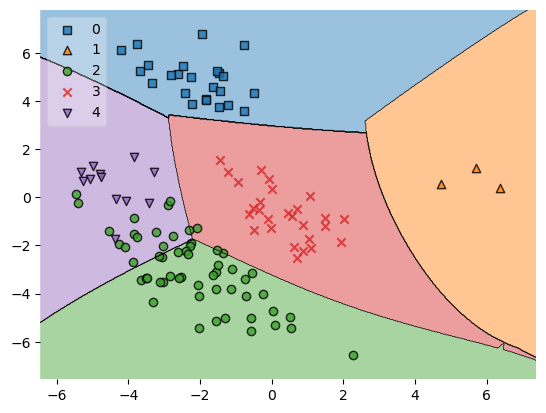

In [23]:
plot_decision_regions(T5_new, np.array(y_test), clf=svc, legend=2)

**B.** Again for those best C,gamma values in part A, what are the training and test scores on the same training and test data, but using PCA reduction down to 3, 9 (as in ps5), and the full 60 dimensionsional data?

In [24]:
# PCA 3

In [25]:
svc = SVC(gamma = best_gamma, C = best_c)
pca3 = PCA(n_components=3)
M5_new = pca3.fit_transform(M5_scaled)
T5_new = pca3.transform(scaler5.transform(T5))
svc.fit(M5_new, y_train)
f'train score: {svc.score(M5_new, y_train)}'

'train score: 1.0'

In [26]:
y_test = [0] * 24 + [1]*3 + [2]*56 + [3]*27 + [4]*12
f'test score {round(svc.score(T5_new, y_test),3)}'

'test score 1.0'

In [27]:
# PCA 9

In [28]:
pca9 = PCA(n_components=9)
M5_new = pca9.fit_transform(M5_scaled)
T5_new = pca9.transform(scaler5.transform(T5))
svc.fit(M5_new, y_train)
f'train score: {svc.score(M5_new, y_train)}'

'train score: 1.0'

In [29]:
y_test = [0] * 24 + [1]*3 + [2]*56 + [3]*27 + [4]*12
f'test score {round(svc.score(T5_new, y_test),3)}'

'test score 0.959'

In [30]:
# PCA 60

In [31]:
pca60 = PCA(n_components=60)
M5_new = pca60.fit_transform(M5_scaled)
T5_new = pca60.transform(scaler5.transform(T5))
svc.fit(M5_new, y_train)
f'train score: {svc.score(M5_new, y_train)}'

'train score: 1.0'

In [32]:
y_test = [0] * 24 + [1]*3 + [2]*56 + [3]*27 + [4]*12
f'test score {round(svc.score(T5_new, y_test),3)}'

'test score 0.598'

## 2) Stylometrics with letter 3-grams

Data: download and unpack the file [ps6data.tar.gz](https://courses.cit.cornell.edu/info3950_2023sp/ps6data.tar.gz) (or equivalently [ps6data.zip](https://courses.cit.cornell.edu/info3950_2023sp/ps6data.zip)).
It has a file auths.txt giving the names of the 20 NYTimes columnists used in the data, and subdirectories train/ and test/:<br>
The train/ subdirectory in turn has 20 subdirectories, labelled by author initials, each of which contains 32 text files by that author. Those are the training and validation files. The test/ subdirectory also has 20 subdirectories, each of which contains 10 additional text files by that author.

You should calculate the letter 3-gram features for each item as in [lec18_l3g_sty.ipynb](https://nbviewer.org/url/courses.cit.cornell.edu/info3950_2023sp/lec18_l3g_sty.ipynb), with one modification.
Calculate the most common features to use as usual, by counting the total number of occurrences in the training set.
But when using those to calculate the features for each individual item, divide the number counts by the length of the text (since the texts are of varying lengths, this will prevent the properties of longer texts from dominating). 

In [33]:
import os
import glob

train_path = "ps6data/train/*/*.txt"
test_path = "ps6data/test/*/*.txt"

train_files = glob.glob(train_path)
test_files = glob.glob(test_path)

train_data = []
for file in train_files:
    with open(file, 'r') as f:
        train_data.append(f.read())

test_data = []
for file in test_files:
    with open(file, 'r') as f:
        test_data.append(f.read())
        
y_train = np.array([[i]*32 for i in range(20)]).flatten()
y_test = np.array([[i]*10 for i in range(20)]).flatten()

In [34]:
len(train_data)

640

In [35]:
auths_list = glob.glob('ps6data/train/*')
auths = [item[-2:] for item in auths_list]

In [36]:
np.logspace(-1,6,8)

array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])

**A.** i) Start with the most common 1500 features as in [lec18_l3g_sty.ipynb](https://nbviewer.org/url/courses.cit.cornell.edu/info3950_2023sp/lec18_l3g_sty.ipynb). On the training set (the 32 items for each of 20 authors), use cv=8 cross validation (which will result in 32/8 = 4 items in each test split for each author) to find the best values of the parameters C and gamma, using GridSearchCV as in lec18_l3g_sty.ipynb.

ii) Plot the training and test scores for the 8 splits using those best values of C and gamma, and indicate the average test and training scores.

iii) Plot a confusion matrix for the full `32*20 = 640` test items. Which authors are the most confused?

In [37]:
# A i
N = 1500
allcounts = Counter()
for text in train_data:
    text = re.sub('\s+',' ', text.lower())

    counter = Counter([text[i:i+3] for i in range(len(text))])
    allcounts += Counter(counter)
top1500 = dict(allcounts.most_common(N)).keys()

In [38]:
M = []
for t in train_data:
    c = Counter([t[i:i+3] for i in range(5000-2)])
    M.append([c[g3] for g3 in top1500])

In [39]:
M=np.array(M)
M.shape

(640, 1500)

In [40]:
T = []
for t in test_data:
    c = Counter([t[i:i+3] for i in range(5000-2)])
    T.append([c[g3] for g3 in top1500])

T=np.array(T)

In [41]:
T.shape

(200, 1500)

In [42]:
scaler = preprocessing.StandardScaler()
M_scaled = scaler.fit_transform(M) #does svc need the scaling ?!?
T_scaled = scaler.fit_transform(T)
M_scaled.shape, T_scaled.shape

((640, 1500), (200, 1500))

In [43]:
param_grid = {'C': np.logspace(-2,10,20),
              'gamma': np.logspace(-9,3,20) }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=8, return_train_score=True)
print(clf.get_params())

{'cv': 8, 'error_score': nan, 'estimator__C': 1.0, 'estimator__break_ties': False, 'estimator__cache_size': 200, 'estimator__class_weight': 'balanced', 'estimator__coef0': 0.0, 'estimator__decision_function_shape': 'ovr', 'estimator__degree': 3, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf', 'estimator__max_iter': -1, 'estimator__probability': False, 'estimator__random_state': None, 'estimator__shrinking': True, 'estimator__tol': 0.001, 'estimator__verbose': False, 'estimator': SVC(class_weight='balanced'), 'n_jobs': None, 'param_grid': {'C': array([1.00000000e-02, 4.28133240e-02, 1.83298071e-01, 7.84759970e-01,
       3.35981829e+00, 1.43844989e+01, 6.15848211e+01, 2.63665090e+02,
       1.12883789e+03, 4.83293024e+03, 2.06913808e+04, 8.85866790e+04,
       3.79269019e+05, 1.62377674e+06, 6.95192796e+06, 2.97635144e+07,
       1.27427499e+08, 5.45559478e+08, 2.33572147e+09, 1.00000000e+10]), 'gamma': array([1.00000000e-09, 4.28133240e-09, 1.83298071e-08, 7.84759970e-08,
    

In [44]:
%%time
clf = clf.fit(M_scaled, y_train)

CPU times: user 20min 18s, sys: 6.19 s, total: 20min 25s
Wall time: 20min 26s


In [45]:
clf.best_estimator_

SVC(C=61.584821106602604, class_weight='balanced', gamma=2.6366508987303556e-05)

In [46]:
best_c = grid.best_params_['C']
best_c

100

In [47]:
# A ii

In [48]:
train_scores = []
bi = clf.best_index_
for i in range(8):
    score = clf.cv_results_[f'split{i}_train_score'][bi] 
    train_scores.append(score)
    
test_scores = []
for i in range(8):
    score = clf.cv_results_[f'split{i}_test_score'][bi] 
    test_scores.append(score)

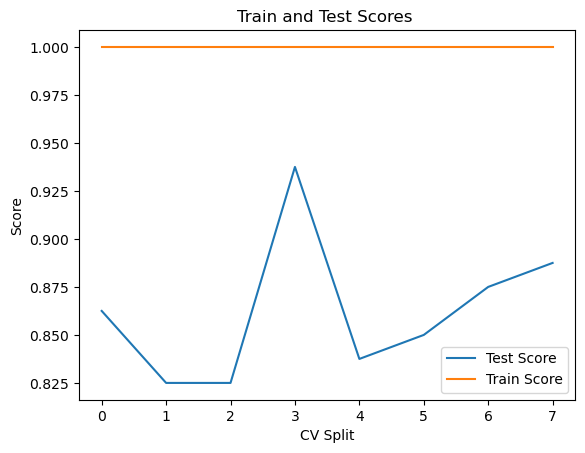

'Mean Train Score: 100.0% || Mean Test Score 86.25%'

In [49]:
plt.plot(test_scores, label='Test Score')
plt.plot(train_scores, label='Train Score')

plt.title('Train and Test Scores ')
plt.xlabel('CV Split')
plt.ylabel('Score')
plt.legend()
plt.show();

mean_train_score = np.mean(train_scores)*100
mean_test_score = np.mean(test_scores)*100
f'Mean Train Score: {round(mean_train_score,2)}% || Mean Test Score {round(mean_test_score,2)}%'

In [50]:
# A iii

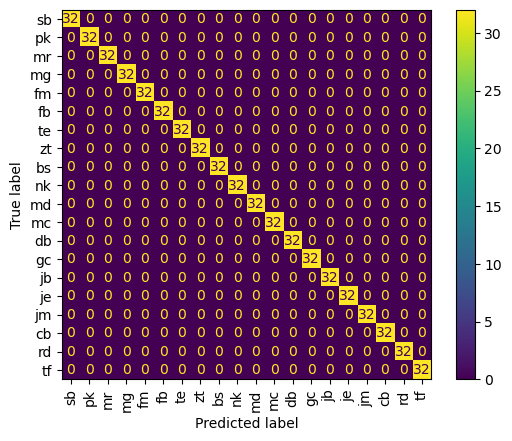

In [51]:
ConfusionMatrixDisplay.from_estimator(clf,M_scaled,y_train,
                    display_labels=auths, xticks_rotation='vertical');

**B.**  i) Now determine the accuracy score on the test data (the additional 10 items for each of the 20 authors), and draw a contingency matrix for performance on the test data for the 20 authors.

ii) Plot the training and test scores as a function of the number of features, as in [lec18_l3g_sty.ipynb](https://nbviewer.org/url/courses.cit.cornell.edu/info3950_2023sp/lec18_l3g_sty.ipynb), from 1 to 2000 features (or more), using the optimal C,gamma from part A. 

In [52]:
# B i

In [53]:
clf.score(T_scaled, y_test)

0.77

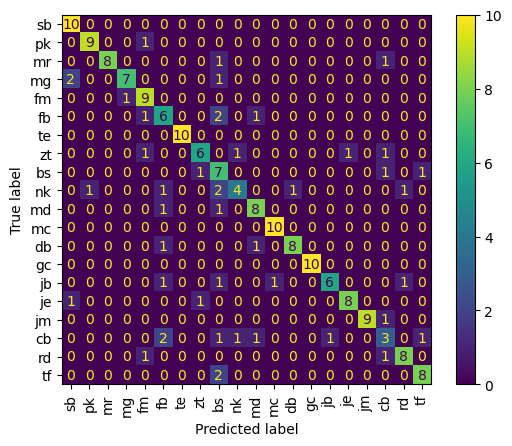

In [54]:
ConfusionMatrixDisplay.from_estimator(clf,T_scaled,y_test,
                    display_labels=auths, xticks_rotation='vertical');

In [55]:
# B ii

In [56]:
X_data = np.concatenate([M,T])
y_data = np.concatenate([y_train,y_test])

In [57]:
X_data.shape

(840, 1500)

In [58]:
clf = SVC(C=61.58,gamma=.00002636)
nfs = [1,10,25,50,75,100,250,500,750,1000,1500,2000] # + list(range(1000,5100,500))

In [59]:
test_means = []
train_means = []
for Nf in nfs:
    cv10 = cross_validate(clf, X_data[:,:Nf], y_data, cv=5, return_train_score=True)
    test_means.append(cv10['test_score'].mean())
    train_means.append(cv10['train_score'].mean())

In [60]:
test_means

[0.09285714285714285,
 0.25833333333333336,
 0.3476190476190476,
 0.42976190476190473,
 0.5154761904761905,
 0.5714285714285714,
 0.7130952380952381,
 0.7797619047619048,
 0.8059523809523809,
 0.8095238095238095,
 0.8261904761904763,
 0.8261904761904763]

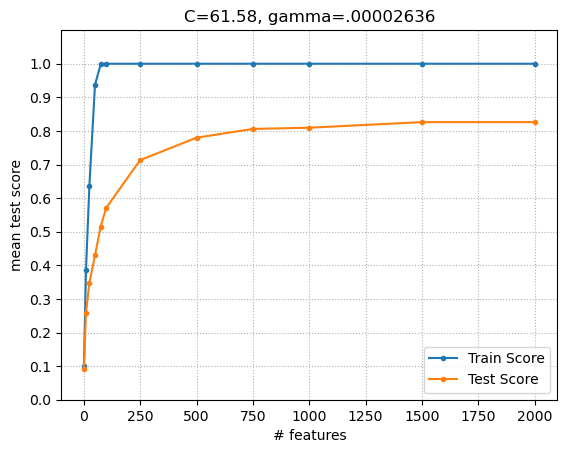

In [61]:
plt.plot(nfs, train_means,'.-', label='Train Score')
plt.plot(nfs, test_means, '.-', label='Test Score')
plt.ylim(0,1)
plt.title('C=61.58, gamma=.00002636')
plt.xlabel('# features')
plt.ylabel('mean test score')
plt.yticks(np.arange(0,1.1,.1))
plt.ylim(0,1.1)
plt.legend()
plt.grid(ls=':');